<a href="https://colab.research.google.com/github/programminghumanity/iphs200fall2020/blob/main/polysci_politician_voting_clusters_20201130.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Politicans and Voting Clusters**

Reference:

* Kaggle notebook by the same name 'Politican Voting Clusters' by
* https://www.kaggle.com/jchun2000/kaggle-politicianvotingclusters-20201128

# How do members of congress tend to vote in relation to each other?
### I'm hoping to see how similar individual house members votes' tend to be.
There's a good chance that I'll see two major groupings, since politically, votes tend to be distributed along party lines. But more than that, I want to be able to connect names to other names. If Representative 1 votes yes, does that imply that Representative 2 will also vote yes?

The original thought was to use clustering methods, but I wanted to get more granular than that. And after visualizing the data, it was clear that there were only two obvious clusters, clearly delineated by political party. Instead, I went for an interactive display that shows name, party, and state for each representative in the voting space. Before constructing this, I want to ensure that the data is cleaned, and that the votes being analyzed are those that have legal impact. This means removing many of the votes, since many of those are on day to day procedural events. 

In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [2]:
%cd ./MyDrive/courses/2020f_iphs200_programming_humanity/code/polysci/

/gdrive/MyDrive/courses/2020f_iphs200_programming_humanity/code/polysci


In [3]:
!ls -al 

total 181
-rw------- 1 root root  3565 Dec  9 17:05 house_members_116.csv
-rw------- 1 root root 99520 Dec  9 17:13 house_rollcall_info_116.csv
-rw------- 1 root root 69017 Dec  9 17:06 house_rollcall_votes_116.csv
-rw------- 1 root root 12793 Dec  9 20:19 polysci_politician-voting-clusters_20201130.ipynb


In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import sklearn.cluster as cls
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
# Input data files are available in the directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('.'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

./house_members_116.csv
./house_rollcall_votes_116.csv
./house_rollcall_info_116.csv
./polysci_politician-voting-clusters_20201130.ipynb


In [6]:
members = pd.read_csv("house_members_116.csv", index_col="name_id")
attendance = pd.read_csv("house_rollcall_info_116.csv")
votes = pd.read_csv("house_rollcall_votes_116.csv", index_col="name_id")

def summarize(df):
    print("Columns:")
    print(df.columns)
    print("\n\n\n\n\nFirst 5 entries:")
    print(df.head())
    print("\n\n\n\n\nDescriptive Stats:")
    print(df.describe())
    print("\n\n\n\n\nMissing Info:")
    print(df.info())

# 1. Files overview

In [10]:
members.head()

,name,state,url,chamber,current_party,committee_assignments
name_id,,,,,,
B001302,andy-biggs,Arizona,https://www.congress.gov/member/andy-biggs/B00...,House,Republican,"['Judiciary', 'Science, Space, and Technology']"
D000624,debbie-dingell,Michigan,https://www.congress.gov/member/debbie-dingell...,House,Democratic,"['Energy and Commerce', 'Natural Resources']"
G000551,raul-grijalva,Arizona,https://www.congress.gov/member/raul-grijalva/...,House,Democratic,"['Natural Resources, Chair', 'Education and La..."
G000576,glenn-grothman,Wisconsin,https://www.congress.gov/member/glenn-grothman...,House,Republican,"['Education and Labor', 'Oversight and Reform']"
K000368,ann-kirkpatrick,Arizona,https://www.congress.gov/member/ann-kirkpatric...,House,Democratic,"['Agriculture', 'Appropriations']"


In [12]:
members.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24 entries, B001302 to B001296
Data columns (total 6 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   name                   24 non-null     object
 1   state                  24 non-null     object
 2   url                    24 non-null     object
 3   chamber                24 non-null     object
 4   current_party          24 non-null     object
 5   committee_assignments  24 non-null     object
dtypes: object(6)
memory usage: 1.9+ KB


In [11]:
summarize(members)

Columns:
Index(['name', 'state', 'url', 'chamber', 'current_party',
       'committee_assignments'],
      dtype='object')





First 5 entries:
                    name  ...                              committee_assignments
name_id                   ...                                                   
B001302       andy-biggs  ...    ['Judiciary', 'Science, Space, and Technology']
D000624   debbie-dingell  ...       ['Energy and Commerce', 'Natural Resources']
G000551    raul-grijalva  ...  ['Natural Resources, Chair', 'Education and La...
G000576   glenn-grothman  ...    ['Education and Labor', 'Oversight and Reform']
K000368  ann-kirkpatrick  ...                  ['Agriculture', 'Appropriations']

[5 rows x 6 columns]





Descriptive Stats:
                    name    state  ... current_party committee_assignments
count                 24       24  ...            24                    24
unique                24        5  ...             2                    23
top     barry-lou

In [9]:
attendance.head()

,rollcall_id,roll_num,date,bill_id,question,result,description,year,congress,session
0,2019:001,1,3-Jan,QUORUM,Call by States,P,NaN,2019,116,1
1,2019:002,2,3-Jan,NaN,Election of the Speaker,P,,2019,116,1
2,2019:003,3,3-Jan,H.RES.5,On Motion to Table the Motion to Refer,P,"Providing for consideration of H.Res. 6, adopt...",2019,116,1
3,2019:004,4,3-Jan,H.RES.5,On Ordering the Previous Question,P,"Providing for consideration of H.Res. 6, adopt...",2019,116,1
4,2019:005,5,3-Jan,H.RES.5,On Motion to Commit with Instructions,F,"Providing for consideration of H.Res. 6, adopt...",2019,116,1


In [13]:
attendance.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 642 entries, 0 to 641
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   rollcall_id  642 non-null    object
 1   roll_num     642 non-null    int64 
 2   date         642 non-null    object
 3   bill_id      641 non-null    object
 4   question     642 non-null    object
 5   result       642 non-null    object
 6   description  641 non-null    object
 7   year         642 non-null    int64 
 8   congress     642 non-null    int64 
 9   session      642 non-null    int64 
dtypes: int64(4), object(6)
memory usage: 50.3+ KB


In [7]:
summarize(attendance)

Columns:
Index(['rollcall_id', 'roll_num', 'date', 'bill_id', 'question', 'result',
       'description', 'year', 'congress', 'session'],
      dtype='object')





First 5 entries:
  rollcall_id  roll_num   date  ...  year congress session
0    2019:001         1  3-Jan  ...  2019      116       1
1    2019:002         2  3-Jan  ...  2019      116       1
2    2019:003         3  3-Jan  ...  2019      116       1
3    2019:004         4  3-Jan  ...  2019      116       1
4    2019:005         5  3-Jan  ...  2019      116       1

[5 rows x 10 columns]





Descriptive Stats:
         roll_num    year  congress  session
count  642.000000   642.0     642.0    642.0
mean   321.500000  2019.0     116.0      1.0
std    185.473718     0.0       0.0      0.0
min      1.000000  2019.0     116.0      1.0
25%    161.250000  2019.0     116.0      1.0
50%    321.500000  2019.0     116.0      1.0
75%    481.750000  2019.0     116.0      1.0
max    642.000000  2019.0     116.0      1.0





Missing

In [14]:
votes.head()

,2029:41:00,2029:39:00,2029:40:00,2029:35:00,2029:36:00,2029:42:00,2029:34:00,2029:37:00,2029:38:00,2029:01:00,2029:00:00,2029:23:00,2027:19:00,2029:02:00,2029:03:00,2023:44:00,2023:59:00,2023:45:00,2022:59:00,2025:09:00,2025:08:00,2023:18:00,2025:10:00,2022:23:00,2022:22:00,2022:21:00,2022:29:00,2024:01:00,2024:00:00,2020:41:00,2022:20:00,2019:01:00,2020:40:00,2019:02:00,2019:05:00,2019:06:00,2019:04:00,2019:03:00,2020:43:00,2019:09:00,...,2020:39:00,2027:08:00,2027:11:00,2027:09:00,2027:14:00,2027:12:00,2027:15:00,2027:13:00,2027:18:00,2027:17:00,2027:16:00,2029:05:00,2029:06:00,2029:04:00,2029:11:00,2029:08:00,2029:07:00,2029:12:00,2029:10:00,2029:09:00,2029:13:00,2029:14:00,2029:15:00,2029:16:00,2029:19:00,2029:18:00,2029:17:00,2029:26:00,2029:22:00,2029:21:00,2029:27:00,2029:25:00,2029:28:00,2029:24:00,2029:20:00,2029:32:00,2029:29:00,2029:31:00,2029:33:00,2029:30:00
name_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
B001302,No,Aye,No,Yea,Yea,No,Nay,No,Aye,Aye,Aye,Aye,Yea,No,Nay,Aye,No,No,Aye,Aye,Aye,No,No,Yea,Nay,No,Yea,No,No,No,Aye,Present,No,Jordan,Yea,Nay,Nay,Nay,Nay,No,...,Nay,Nay,No,Nay,No,Nay,Aye,Yea,Nay,Yea,No,Aye,Aye,Nay,Nay,Aye,No,Yea,Yea,No,Yea,Nay,Nay,Nay,Aye,No,Aye,Nay,Aye,No,Nay,Nay,Nay,No,Aye,Nay,Nay,Nay,Nay,Nay
B001296,Aye,Aye,Aye,Yea,Yea,Aye,Yea,No,Aye,No,No,No,Yea,Aye,Yea,No,Aye,No,No,No,No,Aye,Aye,Yea,Yea,No,Yea,Aye,Aye,Aye,Aye,Present,Aye,Pelosi,Nay,Yea,Yea,Yea,Yea,Aye,...,Yea,Yea,Aye,Yea,Aye,Yea,No,Yea,Yea,Yea,Aye,No,No,Yea,Yea,No,Aye,Yea,Yea,Aye,Yea,Yea,Yea,Yea,Aye,No,Aye,Yea,Aye,Aye,Yea,Yea,Yea,Aye,No,Yea,Yea,Yea,Yea,Yea
D000624,Aye,Aye,Aye,Yea,Yea,Aye,Yea,No,Aye,No,No,No,Yea,Aye,Yea,No,Aye,No,No,No,No,Aye,Aye,Not Voting,Yea,No,Yea,Aye,Aye,Aye,Aye,Present,Aye,Pelosi,Nay,Yea,Yea,Yea,Yea,Aye,...,Yea,Yea,Aye,Yea,Aye,Yea,No,Yea,Yea,Nay,Aye,No,No,Yea,Yea,No,Aye,Yea,Yea,Aye,Yea,Yea,Yea,Yea,Aye,No,Aye,Yea,Aye,Aye,Yea,Yea,Yea,Aye,No,Yea,Yea,Yea,Yea,Yea
E000296,Not Voting,Not Voting,Not Voting,Yea,Yea,Not Voting,Yea,Not Voting,Not Voting,No,No,No,Yea,Aye,Yea,No,Aye,No,No,No,No,Aye,Aye,Yea,Yea,No,Yea,Aye,Aye,Aye,Aye,Present,Aye,Pelosi,Nay,Yea,Yea,Yea,Yea,Aye,...,Yea,Yea,Aye,Yea,Aye,Yea,No,Yea,Yea,Yea,Aye,No,No,Yea,Yea,No,Aye,Yea,Yea,Aye,Yea,Yea,Yea,Yea,Aye,No,Aye,Yea,Aye,Aye,Yea,Yea,Yea,Aye,No,Yea,Yea,Yea,Yea,Yea
G000574,Aye,Aye,Aye,Yea,Yea,Aye,Yea,No,Aye,No,No,Not Voting,Yea,Aye,Yea,No,Aye,No,No,No,No,Aye,Aye,Yea,Yea,No,Yea,Aye,Aye,Aye,Aye,Present,Aye,Pelosi,Nay,Yea,Yea,Yea,Yea,Aye,...,Yea,Yea,Aye,Yea,Aye,Yea,No,Yea,Yea,Yea,Aye,No,No,Yea,Yea,No,Aye,Yea,Yea,Aye,Yea,Yea,Yea,Yea,Not Voting,Not Voting,Not Voting,Yea,Not Voting,Not Voting,Yea,Yea,Yea,Not Voting,Not Voting,Yea,Yea,Yea,Yea,Yea


In [17]:
votes.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24 entries, B001302 to T000481
Columns: 642 entries, 2029:41:00 to 2029:30:00
dtypes: object(642)
memory usage: 120.6+ KB


In [16]:
summarize(votes)

Columns:
Index(['2029:41:00', '2029:39:00', '2029:40:00', '2029:35:00', '2029:36:00',
       '2029:42:00', '2029:34:00', '2029:37:00', '2029:38:00', '2029:01:00',
       ...
       '2029:27:00', '2029:25:00', '2029:28:00', '2029:24:00', '2029:20:00',
       '2029:32:00', '2029:29:00', '2029:31:00', '2029:33:00', '2029:30:00'],
      dtype='object', length=642)





First 5 entries:
         2029:41:00  2029:39:00  2029:40:00  ... 2029:31:00 2029:33:00 2029:30:00
name_id                                      ...                                 
B001302          No         Aye          No  ...        Nay        Nay        Nay
B001296         Aye         Aye         Aye  ...        Yea        Yea        Yea
D000624         Aye         Aye         Aye  ...        Yea        Yea        Yea
E000296  Not Voting  Not Voting  Not Voting  ...        Yea        Yea        Yea
G000574         Aye         Aye         Aye  ...        Yea        Yea        Yea

[5 rows x 642 columns]





Descriptive 

# 2. Cleaning
Okay, since we've now got basic summaries of each of the files we're concerned about, we can start cleaning. This will involve removing unneeded columns, changing votes to numbers, and removing the votes on bills that are not legally impactful.

In [18]:
attendance = attendance[['rollcall_id', 'bill_id']].dropna()

import re
p = re.compile("[HS].((R.)|(j.res.))?[0-9]*.$",re.IGNORECASE)
attendance = attendance[attendance["bill_id"].apply(lambda x: pd.notnull(p.match(x)))]
print(attendance.head())

   rollcall_id    bill_id
7     2019:008  H.J.RES.1
8     2019:009  H.J.RES.1
9     2019:010     H.R.21
10    2019:011     H.R.21
12    2019:013    H.R.269


In [19]:
print(votes.head())


ls = []
for col in votes.columns:
    ls += list(pd.unique(votes[col]))
ls = pd.unique(ls)
print(ls)


# turn strings to booleans
def simplify_strings(x):
    votes_to_bool = {1: ["Aye", "Yea"], -1: ["No", "Nay"], 0:[np.nan, "Not Voting", "Present"]}
    for key, ls in votes_to_bool.items():
        if x in ls:
            return key

for col in votes.columns:
    votes[col] = votes[col].apply(simplify_strings)

         2029:41:00  2029:39:00  2029:40:00  ... 2029:31:00 2029:33:00 2029:30:00
name_id                                      ...                                 
B001302          No         Aye          No  ...        Nay        Nay        Nay
B001296         Aye         Aye         Aye  ...        Yea        Yea        Yea
D000624         Aye         Aye         Aye  ...        Yea        Yea        Yea
E000296  Not Voting  Not Voting  Not Voting  ...        Yea        Yea        Yea
G000574         Aye         Aye         Aye  ...        Yea        Yea        Yea

[5 rows x 642 columns]
['No' 'Aye' 'Not Voting' 'Yea' 'Nay' 'Present' 'Jordan' 'Pelosi'
 'McCarthy']


In [25]:
# Encountering an errors in visualization below
#   because there a empty cells that need to be dropped

# Find out where the null cells are (they are all in column #33) 

np.where(pd.isnull(votes))

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23]),
 array([33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33,
        33, 33, 33, 33, 33, 33, 33]))

In [35]:
# Drop the column with null values

votes.drop(votes.columns[33], axis = 1, inplace=True)

In [36]:
# Check again to be sure there are no more nulls

np.where(pd.isnull(votes))

(array([], dtype=int64), array([], dtype=int64))

In [37]:
votes

,2029:41:00,2029:39:00,2029:40:00,2029:35:00,2029:36:00,2029:42:00,2029:34:00,2029:37:00,2029:38:00,2029:01:00,2029:00:00,2029:23:00,2027:19:00,2029:02:00,2029:03:00,2023:44:00,2023:59:00,2023:45:00,2022:59:00,2025:09:00,2025:08:00,2023:18:00,2025:10:00,2022:23:00,2022:22:00,2022:21:00,2022:29:00,2024:01:00,2024:00:00,2020:41:00,2022:20:00,2019:01:00,2020:40:00,2019:05:00,2019:06:00,2019:04:00,2019:03:00,2020:43:00,2019:09:00,2019:08:00,...,2020:39:00,2027:08:00,2027:11:00,2027:09:00,2027:14:00,2027:12:00,2027:15:00,2027:13:00,2027:18:00,2027:17:00,2027:16:00,2029:05:00,2029:06:00,2029:04:00,2029:11:00,2029:08:00,2029:07:00,2029:12:00,2029:10:00,2029:09:00,2029:13:00,2029:14:00,2029:15:00,2029:16:00,2029:19:00,2029:18:00,2029:17:00,2029:26:00,2029:22:00,2029:21:00,2029:27:00,2029:25:00,2029:28:00,2029:24:00,2029:20:00,2029:32:00,2029:29:00,2029:31:00,2029:33:00,2029:30:00
name_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
B001302,-1,1,-1,1,1,-1,-1,-1,1,1,1,1,1,-1,-1,1,-1,-1,1,1,1,-1,-1,1,-1,-1,1,-1,-1,-1,1,0,-1,1,-1,-1,-1,-1,-1,1,...,-1,-1,-1,-1,-1,-1,1,1,-1,1,-1,1,1,-1,-1,1,-1,1,1,-1,1,-1,-1,-1,1,-1,1,-1,1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1
B001296,1,1,1,1,1,1,1,-1,1,-1,-1,-1,1,1,1,-1,1,-1,-1,-1,-1,1,1,1,1,-1,1,1,1,1,1,0,1,-1,1,1,1,1,1,-1,...,1,1,1,1,1,1,-1,1,1,1,1,-1,-1,1,1,-1,1,1,1,1,1,1,1,1,1,-1,1,1,1,1,1,1,1,1,-1,1,1,1,1,1
D000624,1,1,1,1,1,1,1,-1,1,-1,-1,-1,1,1,1,-1,1,-1,-1,-1,-1,1,1,0,1,-1,1,1,1,1,1,0,1,-1,1,1,1,1,1,-1,...,1,1,1,1,1,1,-1,1,1,-1,1,-1,-1,1,1,-1,1,1,1,1,1,1,1,1,1,-1,1,1,1,1,1,1,1,1,-1,1,1,1,1,1
E000296,0,0,0,1,1,0,1,0,0,-1,-1,-1,1,1,1,-1,1,-1,-1,-1,-1,1,1,1,1,-1,1,1,1,1,1,0,1,-1,1,1,1,1,1,-1,...,1,1,1,1,1,1,-1,1,1,1,1,-1,-1,1,1,-1,1,1,1,1,1,1,1,1,1,-1,1,1,1,1,1,1,1,1,-1,1,1,1,1,1
G000574,1,1,1,1,1,1,1,-1,1,-1,-1,0,1,1,1,-1,1,-1,-1,-1,-1,1,1,1,1,-1,1,1,1,1,1,0,1,-1,1,1,1,1,1,-1,...,1,1,1,1,1,1,-1,1,1,1,1,-1,-1,1,1,-1,1,1,1,1,1,1,1,1,0,0,0,1,0,0,1,1,1,0,0,1,1,1,1,1
G000565,-1,1,-1,1,1,0,-1,-1,1,1,1,1,1,-1,-1,1,-1,1,1,1,-1,-1,-1,1,-1,-1,1,-1,-1,-1,-1,0,-1,1,-1,-1,-1,-1,-1,1,...,-1,-1,-1,-1,-1,-1,1,1,-1,1,-1,1,1,-1,-1,1,-1,1,1,-1,1,1,-1,-1,1,-1,-1,-1,1,-1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1
G000551,1,1,1,1,1,1,1,-1,1,-1,-1,-1,1,1,1,-1,1,-1,-1,-1,-1,1,1,1,1,-1,1,1,1,1,1,0,1,-1,1,1,1,1,1,-1,...,1,1,1,1,1,1,-1,1,1,-1,1,-1,-1,1,1,-1,1,1,1,1,1,1,1,1,1,-1,1,0,1,1,0,0,1,1,-1,1,1,1,1,1
G000576,-1,1,1,1,1,-1,1,1,1,1,1,1,1,-1,-1,1,-1,1,1,1,1,-1,-1,1,-1,1,1,1,-1,-1,1,0,-1,1,-1,-1,-1,-1,-1,1,...,-1,-1,-1,-1,1,-1,1,1,-1,1,-1,1,1,-1,1,1,1,1,1,-1,1,1,-1,-1,1,1,1,1,1,1,-1,-1,-1,-1,1,-1,-1,-1,-1,-1
K000368,1,1,1,1,1,1,1,-1,1,-1,-1,-1,1,1,1,-1,1,-1,-1,0,0,1,0,1,1,-1,1,1,1,1,1,0,1,-1,1,1,1,1,1,-1,...,1,1,1,1,1,1,-1,1,1,1,1,-1,-1,1,1,-1,1,1,1,1,1,1,1,1,1,-1,1,1,1,1,1,1,1,1,-1,1,1,1,1,1


## Procedural votes removed
# 3. Dimension Reduction and Analysis
This leaves us with about 500 recorded votes that have legal impact. However, many of these are uncontroversial, and generally agreed upon. So they are essentially noise. To get to the deeper patterns, I want to focus on which attributes most strongly put representatives into clusters, which suggests a PCA for dimensionality reduction. This also has the benefit of making the information easier to visualize, by compressing the information into as few dimensions as possible.

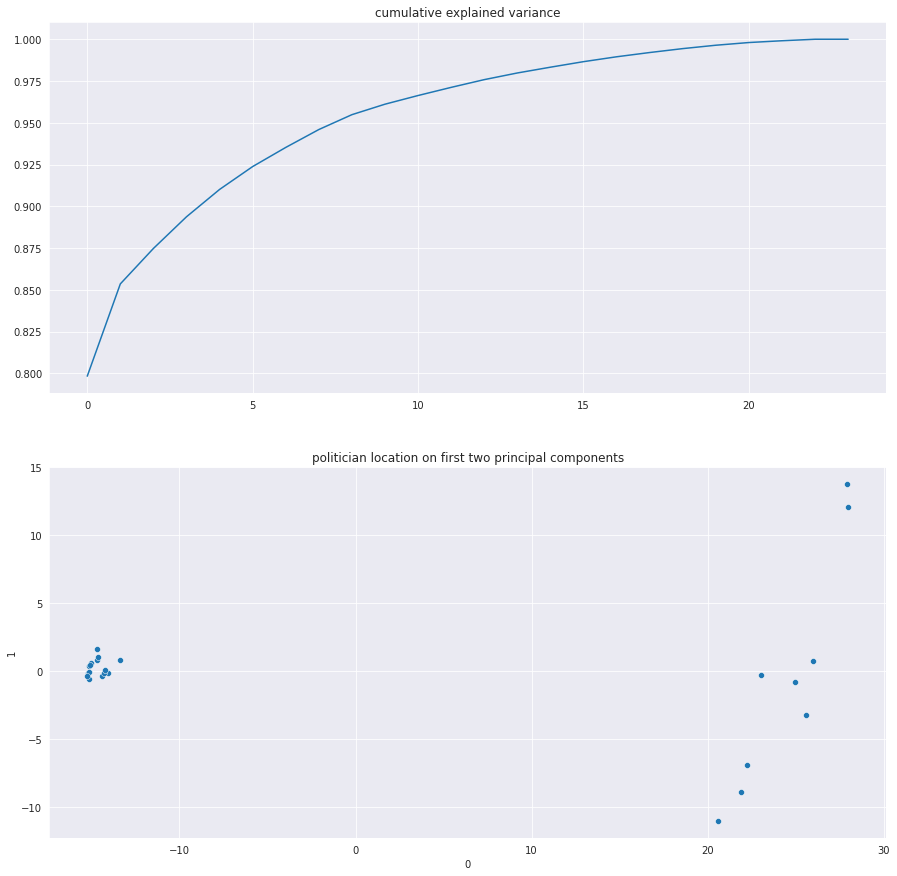

In [38]:
pca = PCA()
pca_votes = pca.fit_transform(votes)
#print(pca_votes.shape)
#print(votes.shape)
pca_votes = pd.DataFrame(pca_votes[:,:2], index = votes.index)

sns.set_style("darkgrid")
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize = (15,15))
sns.lineplot(data = np.cumsum(pca.explained_variance_ratio_), ax=ax1)
sns.scatterplot(x=pca_votes[0], y=pca_votes[1], ax=ax2)#, hue = members.loc[pca_votes.index, "current_party"])

ax1.set_title("cumulative explained variance")
ax2.set_title("politician location on first two principal components")
fig.show()

It's worth noting that the remaining (unvisualized) dimesions from the PCA still contain a fair amount of information, which could concievably be used to cluster the politicians more granularly, but I view that as unlikely, since per the definition of a PCA, they have less variance than the two shown.

In [39]:
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
from bokeh.models.tools import HoverTool
from bokeh.models import ColumnDataSource

output_notebook()
# Basic plot setup
p = figure(width=1200, height=600, title='Politicians in voting space')

a = ColumnDataSource.from_df(pca_votes) # dictionary of arrays {colname:np.array(colvals)}, includes index
a["0"] = a[0]
a['1'] = a[1]
del a[0]
del a[1]
a['current_party'] = np.array(members.loc[votes.index, "current_party"])
a['name']  = np.array(members.loc[votes.index, "name"])
a['state'] = np.array(members.loc[votes.index, "state"])
colors = {"Republican": "firebrick", "Democratic":"navy", "Independent": "green"}
a['color'] = np.array([colors[i] for i in members.loc[votes.index, "current_party"]])

TOOLTIPS = [
    ("name", "@name"),
    ("state", "@state"),
    ("party", "@current_party")
]
cr = p.circle(x="0", y="1", radius=0.3,
              hover_fill_color="cyan",
              fill_alpha=0.8, hover_alpha=0.8, fill_color='color',
              line_color="white", hover_line_color="white", source=a)

p.add_tools(HoverTool(tooltips=TOOLTIPS, renderers=[cr]))

show(p)

The above plot suggests that the members of the 116th house of representatives of congress vote very closely along party lines. However, there are some outliers from the clusters, particularly Nancy Pelosi, Tom Marino, Walter Jones, Dan Bishop, Gregory Murphy, and Brian Fitzpatrick, who appear more willing to compromise, and/or have more moderate views. It appears that the Republican party votes are more diverse than those of the Democratic party. However, one should be very cautious about reading into that, since the axes do not have clear meaning, due to the difficulty in interpreting the bills that were being voted on, and the information compression from the PCA.